<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, GlobalAveragePooling1D, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

rm: cannot remove '*.*': No such file or directory
  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 34.1MB/s]
  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 83.9MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [3]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

In [4]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

In [5]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

## EDA

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0




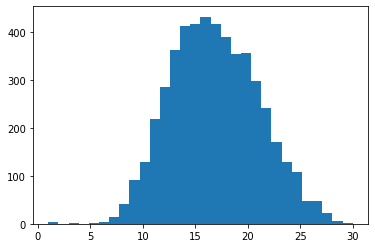

In [6]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [7]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [8]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF
    
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [9]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [10]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


In [12]:
# 단어수 
print(len(set([word for words in train_tweet for word in words.split()])))

NameError: ignored

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 21
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1706
 tweet 의 길이의 중간값 : 10.0




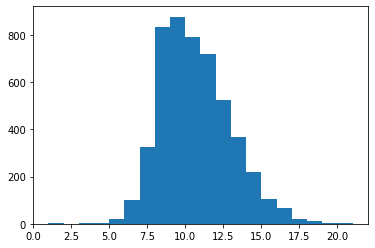

In [13]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

In [14]:
np.quantile(word_count, 0.025)

6.0

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 20
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1968
 tweet 의 길이의 중간값 : 10.0




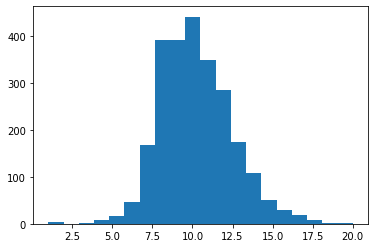

In [15]:
word_count = test_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

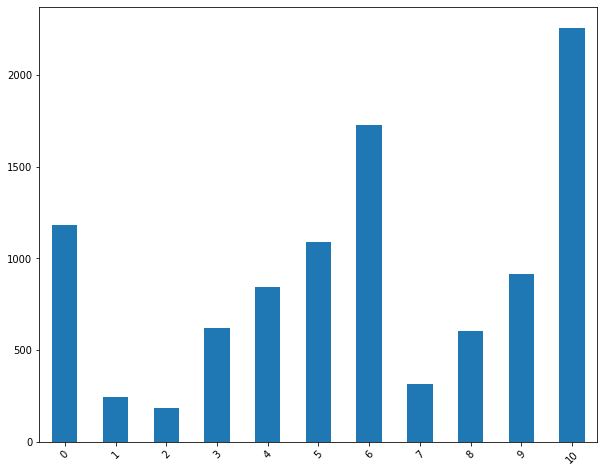

In [16]:
train_df_sentiment = train_df[cols_target]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_df_sentiment.sum(axis=0).plot.bar()
plt.xticks(rotation = 45)
plt.show()

## 토큰화 및 패딩

In [22]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [23]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [25]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [26]:
word_vocab = tokenizer.word_index
#print(word_vocab)

In [27]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [28]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [29]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


## 벡터화


### SENTENCEPIECE

In [30]:
!pip install sentencepiece
import sentencepiece as spm

In [31]:
train_tweet.shape

(5000,)

In [32]:
with open('./full_tweet.txt', 'w', encoding='utf-8') as f:
    for line in train_tweet :
        if len(str(line).strip()) == 0 : continue
        try : 
            f.write(line + '\n')
        except : continue

In [33]:
!cat full_tweet.txt | head -n2

joke hop plane rn well covid lol
banmediahouse whose responsible spreading fake communal story pandemic covid situation


In [34]:
spm.SentencePieceTrainer.train('--input=full_tweet.txt --model_prefix=m --vocab_size=5000')

In [35]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [36]:
train_df['bow'] = train_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))
test_df['bow'] = test_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))

In [37]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."


In [38]:
test_df.head(2)

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."


In [39]:
train_pad = pad_sequences(train_df['bow'].values, maxlen=22)
test_pad = pad_sequences(test_df['bow'].values, maxlen=22)

## 여기부터 볼 것

In [40]:
train_df.head()

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."
2,im waiting someone say covid thing april fool ...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[19, 92, 4, 61, 39, 26, 3, 63, 14, 15, 22]"
3,liar proven day night time lie truth covid,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[970, 233, 1347, 31, 29, 377, 41, 464, 1244, 3]"
4,new u covidvirus death toll reach nearly new d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[33, 17, 6, 34, 219, 79, 450, 1476, 12, 33, 34..."


In [41]:
test_df.head()

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."
2,5003,make covid end na,"[67, 3, 124, 27]"
3,5004,imagine covidvirus pandemic big april fool jok...,"[294, 176, 6, 96, 141, 14, 15, 22, 68, 36, 817..."
4,5005,howdy ana get married covidvirus update gov,"[2797, 135, 5, 566, 21, 2673, 7, 6, 261, 297]"


In [42]:
all_tweet = pd.concat(
    [train_df['Tweet'], test_df['Tweet']] , axis=0
)
all_tweet = all_tweet.reset_index()['Tweet']

In [43]:
all_tweet.values.tolist()[:2]

['joke hop plane rn well covid lol',
 'banmediahouse whose responsible spreading fake communal story pandemic covid situation']

In [44]:
all_texts = all_tweet.values.tolist()

In [45]:
x = train_df.Tweet.values.tolist()
#y = train_df_sentiment.values

In [46]:
x[:2]

['joke hop plane rn well covid lol',
 'banmediahouse whose responsible spreading fake communal story pandemic covid situation']

In [47]:
y[:2]

NameError: ignored

In [48]:
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state =42)
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x)

x_train = tokenizer.texts_to_sequences(x)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
x_train = pad_sequences(x_train, maxlen = maxlen)

(5000, 30)

In [49]:
#glove

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-06-10 14:22:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-10 14:22:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-10 14:22:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [50]:
f = open('glove.6B.100d.txt', encoding="utf8")
embeddings_dictionary = dict()
for line in f:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

f.close()

In [51]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [52]:
embedding_matrix.shape

(8518, 100)

In [53]:
x_train.shape

(5000, 30)

In [54]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [127]:
from keras.models import Sequential, Input, Model
from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from keras.optimizers import Adam

inputs = Input(shape=(maxlen,))
embedding = Embedding(vocab_size,100, weights=[embedding_matrix], trainable = False)(inputs)
layer_ = Conv1D(32, 6, activation='relu')(embedding)
layer_ = Conv1D(32, 6, activation='relu')(layer_)
layer_ = MaxPooling1D(2)(layer_)
layer_ = MaxPooling1D(2)(layer_)

layer_ = Flatten()(layer_)
layer_ = Dense(11, activation='sigmoid')(layer_)

model = Model(inputs, layer_)
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=[f1])
model.summary()



Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 30, 100)           851800    
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 25, 32)            19232     
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 20, 32)            6176      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5, 32)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 160)               0  

In [125]:
model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 30, 100)           851800    
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 25, 32)            19232     
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 20, 32)            6176      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 11)                353

In [91]:
y_train = train_df[cols_target].values

In [92]:
x_train.shape, y_train.shape

((5000, 30), (5000, 11))

In [128]:
model.fit(x_train, y_train, epochs=9, verbose = 1, validation_split = 0.2)

Epoch 1/9
125/125 [==============================] - 2s 10ms/step - loss: 0.4594 - f1: 0.1960 - val_loss: 0.4030 - val_f1: 0.2312
Epoch 2/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3926 - f1: 0.2742 - val_loss: 0.3934 - val_f1: 0.2678
Epoch 3/9
125/125 [==============================] - 1s 8ms/step - loss: 0.3730 - f1: 0.3352 - val_loss: 0.3870 - val_f1: 0.3420
Epoch 4/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3568 - f1: 0.3762 - val_loss: 0.3837 - val_f1: 0.3240
Epoch 5/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3461 - f1: 0.4096 - val_loss: 0.3821 - val_f1: 0.3706
Epoch 6/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3320 - f1: 0.4547 - val_loss: 0.3851 - val_f1: 0.3719
Epoch 7/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3246 - f1: 0.4722 - val_loss: 0.3853 - val_f1: 0.3546
Epoch 8/9
125/125 [==============================] - 1s 7ms/step - loss: 0.3121 - f1: 0.5144 - v

In [129]:
x_tweet = test_df.Tweet.values.tolist()
x_test =tokenizer.texts_to_sequences(x_tweet)
x_test = pad_sequences(x_test, maxlen= maxlen)
x_test.shape

(2500, 30)

In [107]:
res = model.predict(x_test)
res.shape

(2500, 11)

In [108]:
for row in range(2500) :
    
    if max(res[row].tolist()) <= 0.5 :
        idx = res[row].tolist().index(max(res[row].tolist()))
        res[row][idx] = 1 # 결측값 = 확률가장높은 idx에 1 부여
res = res > 0.5
res = pd.DataFrame(res)
res = res.applymap(lambda x : 1 if x else 0)
res[:10]

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,1


In [109]:
res[res.sum(axis=1) == 0]
# 결측값 없음.

,0,1,2,3,4,5,6,7,8,9,10


In [110]:
res.sum(axis=0)

0      312
1       29
2       18
3        1
4       53
5      154
6      327
7        0
8      275
9      113
10    1659
dtype: int64

In [111]:
test_df.head()

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."
2,5003,make covid end na,"[67, 3, 124, 27]"
3,5004,imagine covidvirus pandemic big april fool jok...,"[294, 176, 6, 96, 141, 14, 15, 22, 68, 36, 817..."
4,5005,howdy ana get married covidvirus update gov,"[2797, 135, 5, 566, 21, 2673, 7, 6, 261, 297]"


In [112]:
submission = test_df.drop(['Tweet'], axis=1)
submission['Labels'] = None
submission.head()

,ID,bow,Labels
0,5001,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ...",None
1,5002,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ...",None
2,5003,"[67, 3, 124, 27]",None
3,5004,"[294, 176, 6, 96, 141, 14, 15, 22, 68, 36, 817...",None
4,5005,"[2797, 135, 5, 566, 21, 2673, 7, 6, 261, 297]",None


In [113]:
Res = np.array(res)
Res[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [114]:
for i in range(2500) :
        one_row = []
        for cat in cols_target :
            if int(res[i:i+1][int(cat)].values) == 1 :
                one_row.append(str(cat))
        submission['Labels'][i] = ' '.join(one_row)

In [115]:
submission[140:150]

,ID,bow,Labels
140,5141,"[413, 129, 1648, 255, 1451, 4, 3, 11, 298, 8, ...",0 2
141,5142,"[5, 78, 146, 7, 69, 55, 39, 1842, 1925, 1151, ...",10
142,5143,"[2522, 6, 1242, 36, 99, 986, 445, 845, 4994, 5...",9
143,5144,"[315, 9, 3, 141, 655, 24, 97, 680, 4, 415, 271...",10
144,5145,"[2637, 748, 99, 742, 9, 33, 6, 28, 1792, 90, 6...",8
145,5146,"[419, 4, 2195, 391, 1128, 2410, 5, 3324, 1856,...",10
146,5147,"[1032, 31, 2521, 126, 10, 86, 733, 6, 14, 15, ...",6 10
147,5148,"[66, 26, 3, 232, 9, 4132, 287, 63]",10
148,5149,"[5, 2757, 97, 74, 16, 21, 6, 42, 1813, 208, 30...",10
149,5150,"[19, 211, 4, 2329, 8, 3264, 5, 819, 415, 4, 32...",0


In [116]:
submission

,ID,bow,Labels
0,5001,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ...",10
1,5002,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ...",10
2,5003,"[67, 3, 124, 27]",10
3,5004,"[294, 176, 6, 96, 141, 14, 15, 22, 68, 36, 817...",10
4,5005,"[2797, 135, 5, 566, 21, 2673, 7, 6, 261, 297]",5 10
...,...,...,...
2495,7496,"[5, 792, 2116, 6, 112, 7, 1141, 12, 1513, 923,...",8
2496,7497,"[362, 231, 17, 262, 20, 4, 1801, 743, 3, 950, ...",10
2497,7498,"[129, 455, 3450, 1241, 336, 1030, 783, 3]",0 2
2498,7499,"[230, 272, 596, 1019, 278, 7, 1741, 110, 1989,...",10


In [118]:
submission = submission.drop(['bow'], axis=1)
submission

,ID,Labels
0,5001,10
1,5002,10
2,5003,10
3,5004,10
4,5005,5 10
...,...,...
2495,7496,8
2496,7497,10
2497,7498,0 2
2498,7499,10


In [119]:
submission.to_csv('1DCNN.csv', index=False)
from google.colab import files
files.download('1DCNN.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>